<table align="center" style="text-align:center">
    <tbody>
        <tr>
            <td colspan="15"><img src="https://raw.githubusercontent.com/TomWagg/tomwagg.github.io/main/img/milky_way_dcos.png"/></td>
            <td colspan="50">
                <h1 style="font-size:50px">Fiducial Simulation Analysis</h1>
                <h2 style="font-size:20px;"><i>Part of the notebook series for Wagg et al. 2021</i></h2>
                <p style="font-size:15px;">This notebook demonstrates how to reproduce the plots that examine the fiducial population of Galactic DCOs in Wagg et al. (2021). These mainly show various parameter distributions and cumulative distribution of observables (Figures 3-8). In order to make these plots you'll need the data, which can be found <a href="https://zenodo.org/record/4699713">here</a> on Zenodo.</p>
            </td>
            <td colspan="15"><img src="https://raw.githubusercontent.com/TomWagg/tomwagg.github.io/main/img/milky_way_dcos.png"/></td>
        </tr>
    </tbody>
</table>

In [35]:
# general package imports
import h5py as h5
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
import seaborn as sns
import time

# custom LISA package
import legwork

# import code from repo
import sys
sys.path.append("../../simulation/src/")
from variations import variations
from galaxy import simulate_mw
import bootstrap as boots
import uncertainties as unc

In [36]:
# config stuff to make plots look pretty
%config InlineBackend.figure_format = 'retina'
plt.rc('font', family='serif')
fs = 20

params = {'legend.fontsize': fs,
         'axes.labelsize': fs,
         'xtick.labelsize':0.7*fs,
         'ytick.labelsize':0.7*fs}
plt.rcParams.update(params)

In [37]:
# define what DCOs we are working with and a colour scheme
dco_types = ["BHBH", "BHNS", "NSNS"]
dco_colours = {"BHBH": plt.get_cmap("plasma")(0.2), 
               "BHNS": plt.get_cmap("plasma")(0.5),
               "NSNS": plt.get_cmap("plasma")(0.8)}

# IMPORTANT: these need to point to the folders where you stored the data from Zenodo
data_folder = "../../simulation/data/"
sim_folder = data_folder + "simulation/"
extended_sim_folder = data_folder + "simulation_10yr/"

# load a bunch of data
total_DCOs_in_MW = np.load(data_folder + "total_DCO_in_MW.npy")
detections_4yr = np.load(data_folder + "detections_4yr.npy")
detections_10yr = np.load(data_folder + "detections_10yr.npy")

In [38]:
""" helper function for setting log spaced ticks """
def get_log_ticks(min_log, max_log):
    
    bottom = np.floor(min_log).astype(int)
    top = np.ceil(max_log).astype(int)
    
    ticks = []
    
    for i in range(bottom, top + 1):
        for j in range(2, 10):
            log_tick = np.log10(j * 10**(i))
            if log_tick > bottom and log_tick < top:
                ticks.append(log_tick)
                
    return ticks

# Properties of detectable sources
This section focuses on plots that show the properties of detectable sources, both during the LISA mission and early in their lifetimes.

## Progenitor distributions
First, let's make a two panel plot that shows how the initial primary mass and mass ratio are distributed.

BHBH
	Plotting initial primary mass
	Plotting initial mass ratio

BHNS
	Plotting initial primary mass
	Plotting initial mass ratio

NSNS
	Plotting initial primary mass
	Plotting initial mass ratio



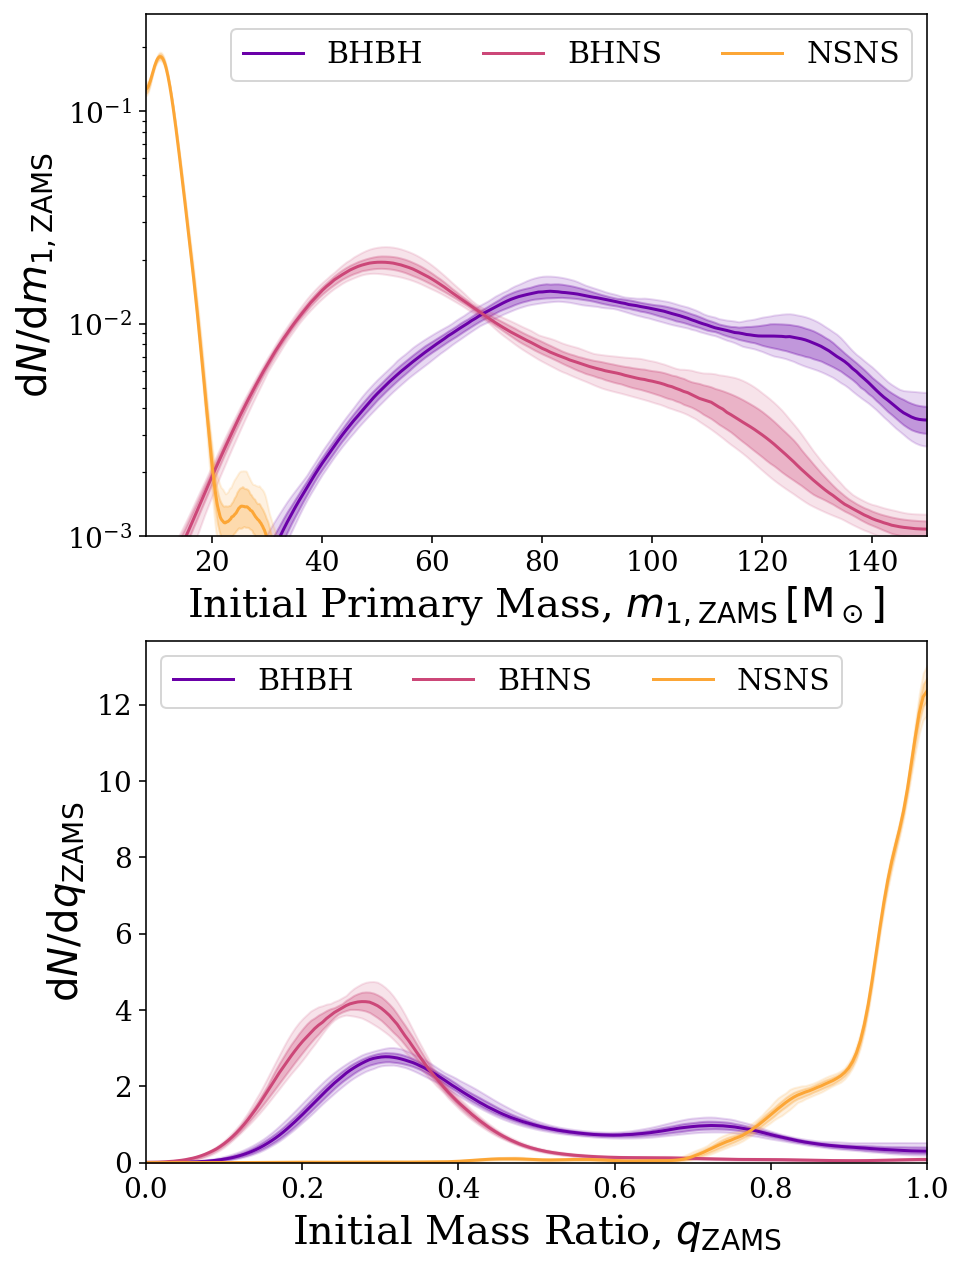

In [54]:
fig, axes = plt.subplots(2, 1, figsize=(7, 11))
fig.subplots_adjust(wspace=0.23, top=0.85)

bootstraps = 200

for i, dco_type in enumerate(dco_types):
    with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, "fiducial"), "r") as f:
        data = f["simulation"][...].squeeze()
        
    f_orb_ZAMS = legwork.utils.get_f_orb_from_a(m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun,
                                                a=data["a_ZAMS"] * u.AU)
    
    q_ZAMS = data["m_2_ZAMS"] / data["m_1_ZAMS"]
    q_ZAMS[q_ZAMS > 1] = 1 / q_ZAMS[q_ZAMS > 1]
    
    print(dco_type)
    
    print("\tPlotting initial primary mass")
    axes[0] = boots.bootstrapped_kde(data["m_1_ZAMS"], data["weight"], data["seed"],
                                     ax=axes[0], color=dco_colours[dco_type], label=dco_type,
                                     bootstraps=bootstraps, lower_bound=8.0, upper_bound=150,
                                     x_min=8, x_max=40 if dco_type == "NSNS" else 150)
    
    axes[0].set_xlabel(r"Initial Primary Mass, $m_{1, {\rm ZAMS}} \, [\rm M_{\rm \odot}]$")
    axes[0].set_xlim(8, 150)
    axes[0].set_ylabel(r"$\mathrm{d}N / \mathrm{d} m_{1, {\rm ZAMS}}$")
    axes[0].set_yscale("log")
    
    print("\tPlotting initial mass ratio")
    axes[1] = boots.bootstrapped_kde(q_ZAMS, data["weight"], data["seed"], bootstraps=bootstraps,
                                     ax=axes[1], color=dco_colours[dco_type], label=dco_type,
                                     x_min=0.0, x_max=1.0, lower_bound=0.0, upper_bound=1.0)
    
    axes[1].set_xlabel(r"Initial Mass Ratio, $q_{\rm ZAMS}$")
    axes[1].set_xlim(0, 1)
    axes[1].set_ylabel(r"$\mathrm{d}N / \mathrm{d} q_{\rm ZAMS}$")
        
    print()

axes[0].legend(loc='upper right', fontsize=0.75*fs, ncol=3)
axes[1].legend(loc='upper left', fontsize=0.75*fs, ncol=3)
    
for ax in axes:
    if ax.get_yscale() == "log":
        ax.set_ylim(bottom=1e-3)
    else:
        ax.set_ylim(bottom=0.0)
    
plt.savefig("../figures/progenitor_distributions.pdf", format="pdf", bbox_inches="tight")
    
plt.show()

## DCO Formation distributions
Similarly, we can make a plot of the separation and eccentricity at the moment of DCO formation.

BHBH
	Plotting eccentricity at DCO
	Plotting separation at DCO

BHNS
	Plotting eccentricity at DCO
	Plotting separation at DCO

NSNS
	Plotting eccentricity at DCO
	Plotting separation at DCO



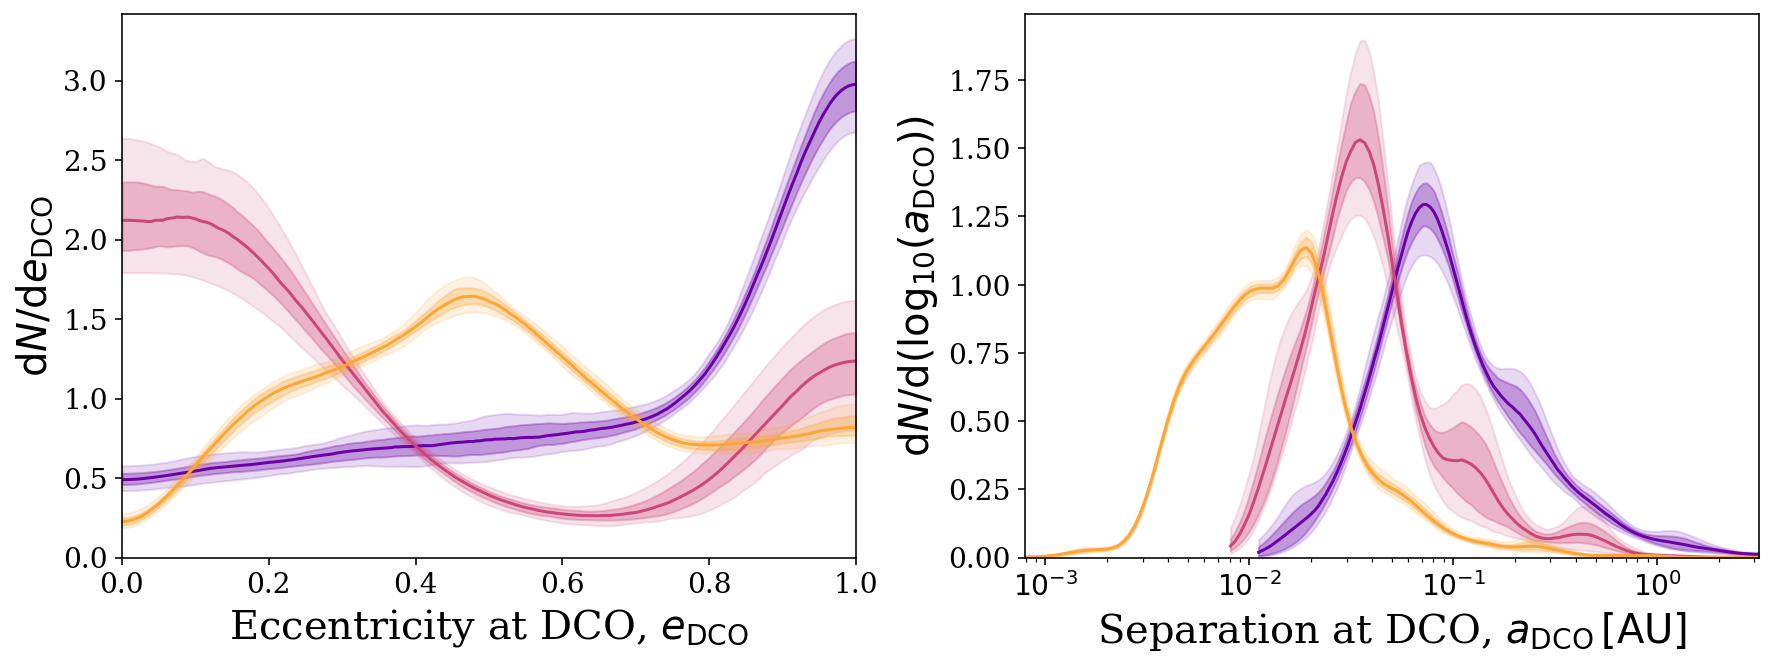

In [773]:
fig, axes = plt.subplots(1, 2, figsize=(14.67, 5))
fig.subplots_adjust(wspace=0.23)

bootstraps = 200
colours = dco_colours

for i, dco_type in enumerate(dco_types):
    with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, "fiducial"), "r") as f:
        data = f["simulation"][...].squeeze()
    
    print(dco_type)
    
    print("\tPlotting eccentricity at DCO")
    
    axes[0] = boots.bootstrapped_kde(data["e_DCO"], data["weight"], data["seed"],
                                     ax=axes[0], color=colours[dco_type], label=dco_type,
                                     bootstraps=bootstraps, lower_bound=0.0, upper_bound=1.0, x_min=0, x_max=1)
    
    print("\tPlotting separation at DCO")
    
    axes[1] = boots.bootstrapped_kde(np.log10(data["a_DCO"]), data["weight"], data["seed"],
                                     ax=axes[1], color=colours[dco_type], label=dco_type,
                                     bootstraps=bootstraps)
    
    print()
    
axes[0].set_xlabel(r"Eccentricity at DCO, $e_{\rm DCO}$")
axes[0].set_xlim(0, 1)
axes[0].set_ylabel(r"$\mathrm{d}N / \mathrm{d} e_{\rm DCO}$")

axes[1].set_xlabel(r"Separation at DCO, $a_{\rm DCO} \, [{\rm AU}]$")
axes[1].set_xlim(-3.1, 0.5)
axes[1].set_xticks([-3, -2, -1, 0])
axes[1].set_xticklabels([r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$", r"$10^0$"])
axes[1].xaxis.set_minor_locator(FixedLocator(get_log_ticks(*axes[1].get_xlim())))
axes[1].set_ylabel(r"$\mathrm{d}N / \mathrm{d}(\log_{10} (a_{\rm DCO}))$")

for ax in axes.flatten():
    if ax.get_yscale() == "log":
        ax.set_ylim(bottom=1e-3)
    else:
        ax.set_ylim(bottom=0.0)
    
plt.savefig("../figures/dco_formation_distributions.pdf", format="pdf", bbox_inches="tight")
    
plt.show()

## Main grid of properties
This grid contains the most important properties of the detectable LISA systems. First we need to calculate the merger time that is left for the systems at the start of the LISA mission (we don't store this from the simulations) and then make the plot.

In [39]:
t_merge_left_all = {
    "BHBH": None,
    "BHNS": None,
    "NSNS": None
}

for dco_type in dco_types:

    with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, "fiducial"), "r") as f:
        full_data = f["simulation"][...].squeeze()
        snr_mask = full_data["snr"] > 7
        data = full_data[snr_mask]
        
        print(dco_type)

        t_merge = legwork.evol.get_t_merge_ecc(ecc_i=data["e_DCO"], a_i=data["a_DCO"] * u.AU,
                                               m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun,
                                               small_e_tol=0.01)

        t_merge_left_all[dco_type] = (t_merge.to(u.Gyr) - (data["tau"] - (data["t_evol"] / 1e3)) * u.Gyr).to(u.Myr)
        print("done")
        print()

BHBH
done

BHNS
done

NSNS
done



In [40]:
def detectable_properties_grid(model=0, t_obs=4 * u.yr, bootstraps=200, dco_types=dco_types,
                               colours=dco_colours, save_fig=True, file_name=None,
                               fig=None, axes=None, show=True,
                               lower_mass_gap=False, eccentricity_labels=False, legend=True):

    start = time.time()

    detection_total = detections_4yr if t_obs == 4 * u.yr else detections_10yr
    
    if fig is None or axes is None:
        fig, axes = plt.subplots(2, 3, figsize=(22, 10))
    plt.subplots_adjust(top=0.92, hspace=0.25, wspace=0.22)
    lw = 4
    
    # loop over each DCO type
    for i, dco_type in enumerate(dco_types):
        # open corresponding COMPAS file
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[model]["file"]), "r") as f:
            full_data = f["simulation"][...].squeeze()
            snr_mask = full_data["snr"] * (t_obs / (4 * u.yr))**(0.5) > 7

            data = full_data[snr_mask]
        
        # convert separation to frequency
        f_orb_LISA = legwork.utils.get_f_orb_from_a(m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun,
                                                    a=data["a_LISA"] * u.AU)
        print(variations[model]["med"], dco_type, len(data["m_1"]))
        
        q = data["m_2"] / data["m_1"]
        q[q > 1] = 1 / q[q > 1]

        # work out which masses are the BH and NS masses
        if dco_type == "BHNS":
            mBH = np.maximum(data["m_1"], data["m_2"])
            mNS = np.minimum(data["m_1"], data["m_2"])
            mass_weights = data["weight"]
            mass_seeds = data["seed"]
        elif dco_type == "BHBH":
            mBH = np.concatenate((data["m_1"], data["m_2"]))
            mass_weights = np.concatenate((data["weight"], data["weight"]))
            mass_seeds = np.concatenate((data["seed"], -1 * data["seed"]))
        elif dco_type == "NSNS":
            mNS = np.concatenate((data["m_1"], data["m_2"]))
            mass_weights = np.concatenate((data["weight"], data["weight"]))
            mass_seeds = np.concatenate((data["seed"], -1 * data["seed"]))
        
        # plot the orbital frequency distribution
        print("\t Plotting orbital frequency")
        if bootstraps is not None:
            axes[0, 0] = boots.bootstrapped_kde(np.log10(f_orb_LISA.value), data["weight"], data["seed"],
                                                ax=axes[0, 0], color=colours[dco_type], label=dco_type,
                                                bootstraps=bootstraps)
        else:
            kde = boots.MirroredKDE(np.log10(f_orb_LISA.value), weights=data["weight"])
            axes[0, 0].plot(*kde.evaluate(), color=colours[dco_type], label=dco_type)
        axes[0, 0].set_xlabel(r"Orbital Frequency, $f_{\rm orb, LISA} \, [\rm Hz]$")
        axes[0, 0].set_xlim(-5.1, -2.1)
        
        axes[0, 0].set_xticks([-5, -4, -3, -2])
        axes[0, 0].set_xticklabels([r"$10^{-5}$", r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$"])
        axes[0, 0].xaxis.set_minor_locator(FixedLocator(get_log_ticks(*axes[0, 0].get_xlim())))
        
        axes[0, 0].set_ylabel(r"$\mathrm{d}N / \mathrm{d}(\log_{10} (f_{\rm orb}))$")
        
        # plot the BH mass distribution
        print("\t Plotting black hole mass")
        if dco_type in ["BHNS", "BHBH"]:
            if bootstraps is not None:
                axes[0, 1] = boots.bootstrapped_kde(mBH, mass_weights, mass_seeds, bw_adjust=1.4,
                                                    ax=axes[0, 1], color=colours[dco_type], label=dco_type,
                                                    bootstraps=bootstraps, lower_bound=0.0, x_min=2.5, x_max=21)
            else:
                kde = boots.MirroredKDE(mBH, weights=mass_weights, lower_bound=0.0, bw_adjust=1.4)
                axes[0, 1].plot(*kde.evaluate(x_min=2.5), color=colours[dco_type], label=dco_type)
            
            if model == 8:
                min_mass = np.min(mBH)
                axes[0, 1].plot([min_mass, min_mass], [0, 0.065], color=colours[dco_type])
            
            axes[0, 1].set_xlabel(r"Black Hole Mass, $m_{\rm BH} \, [\rm M_{\odot}]$")
            axes[0, 1].set_xlim(2.5, 21)
                
            axes[0, 1].set_ylabel(r"$\mathrm{d}N / \mathrm{d} m_{\rm BH}$")
            
            if dco_type == "BHBH":
                ax_right = axes[0, 1].twinx()
                
                kde = boots.MirroredKDE(data["m_1"], weights=data["weight"], lower_bound=0.0, bw_adjust=1.4)
                ax_right.plot(*kde.evaluate(x_min=2.5), color=colours[dco_type], label=dco_type, linestyle="dotted")
                
                kde = boots.MirroredKDE(data["m_2"], weights=data["weight"], lower_bound=0.0, bw_adjust=1.4)
                ax_right.plot(*kde.evaluate(x_min=2.5), color=colours[dco_type], label=dco_type, linestyle="dotted")
                
                ax_right.set_ylim(0, axes[0, 1].get_ylim()[-1] * 4)
                ax_right.set_yticks([])
                ax_right.set_ylabel("")
        
        print("\t Plotting mass ratio")            
        if bootstraps is not None:
            axes[0, 2] = boots.bootstrapped_kde(q, data["weight"], data["seed"], bootstraps=bootstraps,
                                                ax=axes[0, 2], color=colours[dco_type], label=dco_type,
                                                x_min=0.0, x_max=1.0, lower_bound=0.0, upper_bound=1.0)
        else:
            kde = boots.MirroredKDE(q, weights=data["weight"], lower_bound=0.0, upper_bound=1.0)
            axes[0, 2].plot(*kde.evaluate(), color=colours[dco_type], label=dco_type)
        axes[0, 2].set_xlim(0, 1)
        axes[0, 2].set_ylim(0, 10)
        axes[0, 2].set_xlabel(r"Mass Ratio, $q \equiv m_{2} / m_{1}$")
        axes[0, 2].set_ylabel(r"$\mathrm{d}N / \mathrm{d}q$")
        
        if dco_type == "BHNS":
            axes[0, 2].annotate("At least 1 CE", xytext=(0.18, 8), xy=(0.18, 4), va="center", ha="center",
                                rotation=90, fontsize=0.6*fs, color=dco_colours[dco_type],
                                arrowprops=dict(arrowstyle="->", color=dco_colours[dco_type]))
            axes[0, 2].annotate("Only stable MT", xytext=(0.34, 8), xy=(0.34, 4.7), va="center", ha="center",
                                rotation=90, fontsize=0.6*fs, color=dco_colours[dco_type],
                                arrowprops=dict(arrowstyle="->", color=dco_colours[dco_type]))
            
        if dco_type == "NSNS":
            axes[0, 2].annotate("Extends above axis", xy=(0.92, 9.8), xytext=(0.92, 5.5), ha="center",
                                va="center", rotation=90, color=dco_colours[dco_type], fontsize=0.6*fs,
                                arrowprops=dict(arrowstyle="->", color=dco_colours[dco_type]))
            
        # plot the eccentricity distribution
        print("\t Plotting eccentricity")
        if bootstraps is not None:
            axes[1, 0] = boots.bootstrapped_kde(np.log10(data["e_LISA"]), data["weight"], data["seed"],
                                                ax=axes[1, 0], color=colours[dco_type], label=dco_type,
                                                bw_adjust=1.5, bootstraps=bootstraps, upper_bound=0.0)
        else:
            kde = boots.MirroredKDE(np.log10(data["e_LISA"]), weights=data["weight"], upper_bound=0.0, bw_adjust=1.5)
            axes[1, 0].plot(*kde.evaluate(), color=colours[dco_type], label=dco_type)
            
        axes[1, 0].set_xlabel(r"Eccentricity, $e_{\rm LISA}$")
        axes[1, 0].set_xlim(-4.1, 0)
        axes[1, 0].set_xticks([-4, -3, -2, -1, 0])
        axes[1, 0].set_xticklabels([r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$", "1"])
        axes[1, 0].xaxis.set_minor_locator(FixedLocator(get_log_ticks(*axes[1, 0].get_xlim())))
        axes[1, 0].set_ylabel(r"$\mathrm{d}N / \mathrm{d}(\log_{10} (e_{\rm LISA}))$")
        
        # plot the lookback time
        print("\t Plotting lookback time")
        if bootstraps is not None:
            axes[1, 1] = boots.bootstrapped_kde(data["tau"], data["weight"], data["seed"],
                                          ax=axes[1, 1], color=colours[dco_type], label=dco_type,
                                          bootstraps=bootstraps, lower_bound=0.0, upper_bound=12.0, bw_adjust=1.5)
        else:
            kde = boots.MirroredKDE(data["tau"], weights=data["weight"], lower_bound=0.0, upper_bound=12.0, bw_adjust=1.5)
            axes[1, 1].plot(*kde.evaluate(), color=colours[dco_type], label=dco_type)
            
        axes[1, 1].set_xlabel(r"Time since formation, $\tau \, [\rm Gyr]$")
        axes[1, 1].set_xlim(0, 12)
        axes[1, 1].set_ylabel(r"$\mathrm{d}N / \mathrm{d}\tau$")

        print("\t Plotting merger time remaining")
        if bootstraps is not None:
            axes[1, 2] = boots.bootstrapped_kde(np.log10(t_merge_left_all[dco_type].to(u.yr).value),
                                          data["weight"], data["seed"],
                                          ax=axes[1, 2], color=colours[dco_type], label=dco_type,
                                          bootstraps=bootstraps, x_min=3.5, x_max=8.3)
        else:
            kde = boots.MirroredKDE(np.log10(t_merge_left_all[dco_type].to(u.yr).value), weights=data["weight"])
            axes[1, 2].plot(*kde.evaluate(), color=colours[dco_type], label=dco_type)
            
        axes[1, 2].set_xlabel(r"Time until merger, $t_{\rm merge} \, [\rm yr]$")
        axes[1, 2].set_xlim(3.5, 8.3)
        axes[1, 2].set_xticks([4, 5, 6, 7, 8])
        axes[1, 2].set_xticklabels([r"$10^{4}$", r"$10^{5}$", r"$10^{6}$", r"$10^{7}$", r"$10^{8}$"])
        axes[1, 2].xaxis.set_minor_locator(FixedLocator(get_log_ticks(*axes[1, 2].get_xlim())))
        axes[1, 2].set_ylabel(r"$\mathrm{d}N / \mathrm{d}(\log_{10} (t_{\rm merge}))$")

    tau, _, _ = simulate_mw(100000)
    kde = boots.MirroredKDE(tau, weights=None, lower_bound=0.0, upper_bound=12.0)
    axes[1, 1].plot(*kde.evaluate(), color="grey", lw=2, linestyle="dotted")
        
    axes[0, 0].annotate("a", xy=(0.03, 0.97), xycoords="axes fraction", fontsize=fs, va="top", bbox=dict(boxstyle="circle", color="lightgrey", alpha=0.5, pad=0.15))
    axes[0, 1].annotate("b", xy=(0.97, 0.97), xycoords="axes fraction", fontsize=fs, va="top", ha="right", bbox=dict(boxstyle="circle", color="lightgrey", alpha=0.5, pad=0.15))
    axes[0, 2].annotate("c", xy=(0.03, 0.97), xycoords="axes fraction", fontsize=fs, va="top", bbox=dict(boxstyle="circle", color="lightgrey", alpha=0.5, pad=0.15))
    axes[1, 0].annotate("d", xy=(0.03, 0.97), xycoords="axes fraction", fontsize=fs, va="top", bbox=dict(boxstyle="circle", color="lightgrey", alpha=0.5, pad=0.15))
    axes[1, 1].annotate("e", xy=(0.97, 0.97), xycoords="axes fraction", fontsize=fs, va="top", ha="right", bbox=dict(boxstyle="circle", color="lightgrey", alpha=0.5, pad=0.15))
    axes[1, 2].annotate("f", xy=(0.03, 0.97), xycoords="axes fraction", fontsize=fs, va="top", bbox=dict(boxstyle="circle", color="lightgrey", alpha=0.5, pad=0.15))
        
    if lower_mass_gap:
        axes[0, 1].axvspan(2.5, 5.0, color="grey", alpha=0.25)
        axes[0, 1].annotate("Lower mass gap", xy=(3.75, 0.01), color="grey", rotation=90, ha="center", fontsize=0.6*fs)
        
    if eccentricity_labels:
        for e in [0.01, 0.3]:
            axes[1, 0].axvline(np.log10(e), color="grey", linestyle="dotted")
            axes[1, 0].annotate(r"$e = {{{}}}$".format(e), xy=(np.log10(e), 0.04 if e < 0.1 else 0.5), color="grey",
                                bbox=dict(boxstyle="round", ec="white", fc="white"), ha="center", rotation=90, fontsize=0.7*fs)
    
    if legend:
        handles, labels = axes[0, 0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center', fontsize=fs, ncol=3)

    for ax in axes.flatten():
        ax.tick_params(labelsize=0.7*fs)
        ax.xaxis.label.set_fontsize(fs)
        
        if ax.get_yscale() == "linear":
            ax.set_ylim(bottom=0.0)

    if save_fig:
        if file_name is not None:
            plt.savefig("../../paper/figures/" + file_name, format="pdf", bbox_inches="tight")
        elif t_obs == 4 * u.yr:
            plt.savefig("../../paper/figures/detectable_properties_4yr.pdf", format="pdf", bbox_inches="tight")
        else:
            plt.savefig("../../paper/figures/detectable_properties_10yr.pdf", format="pdf", bbox_inches="tight")
        
    print()
    print("Plot complete, it took {:1.1f} seconds".format(time.time() - start))

    if show:
        plt.show()
    
    return fig, axes

fiducial BHBH 46703
	 Plotting orbital frequency
	 Plotting black hole mass
	 Plotting mass ratio
	 Plotting eccentricity
	 Plotting lookback time
	 Plotting merger time remaining
fiducial BHNS 45383
	 Plotting orbital frequency
	 Plotting black hole mass
	 Plotting mass ratio
	 Plotting eccentricity
	 Plotting lookback time
	 Plotting merger time remaining
fiducial NSNS 32803
	 Plotting orbital frequency
	 Plotting black hole mass
	 Plotting mass ratio
	 Plotting eccentricity
	 Plotting lookback time
	 Plotting merger time remaining

Plot complete, it took 866.7 seconds


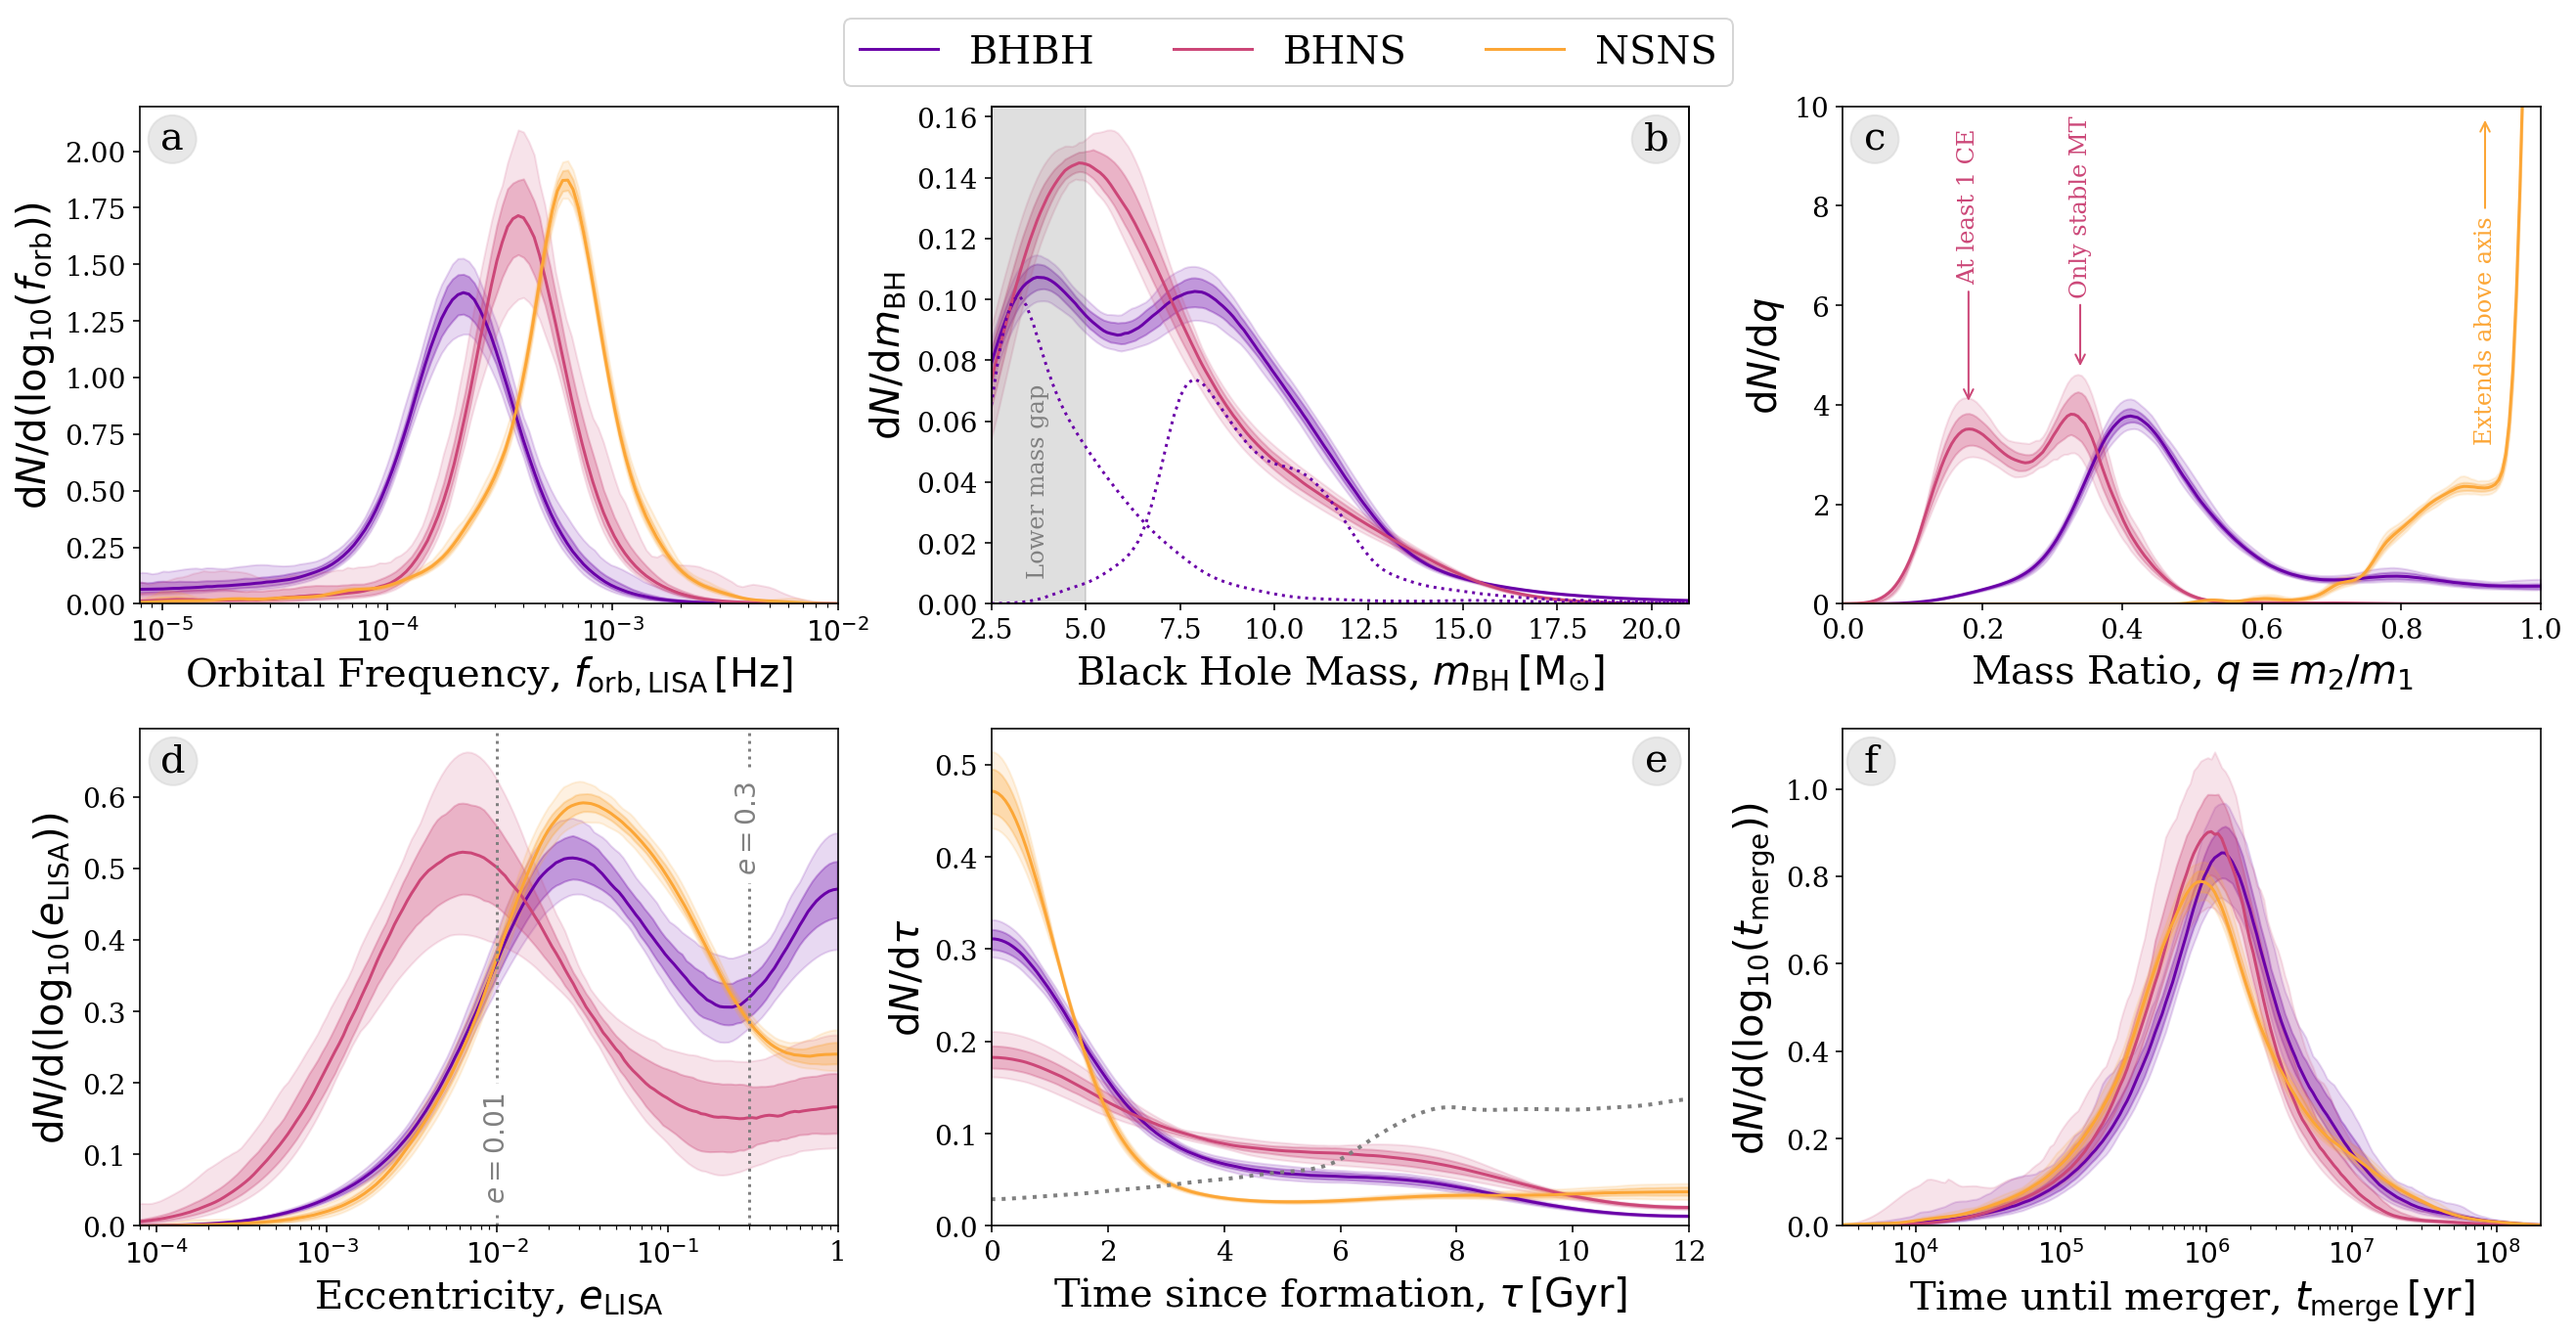

(<Figure size 1584x720 with 7 Axes>,
 array([[<AxesSubplot:xlabel='Orbital Frequency, $f_{\\rm orb, LISA} \\, [\\rm Hz]$', ylabel='$\\mathrm{d}N / \\mathrm{d}(\\log_{10} (f_{\\rm orb}))$'>,
         <AxesSubplot:xlabel='Black Hole Mass, $m_{\\rm BH} \\, [\\rm M_{\\odot}]$', ylabel='$\\mathrm{d}N / \\mathrm{d} m_{\\rm BH}$'>,
         <AxesSubplot:xlabel='Mass Ratio, $q \\equiv m_{2} / m_{1}$', ylabel='$\\mathrm{d}N / \\mathrm{d}q$'>],
        [<AxesSubplot:xlabel='Eccentricity, $e_{\\rm LISA}$', ylabel='$\\mathrm{d}N / \\mathrm{d}(\\log_{10} (e_{\\rm LISA}))$'>,
         <AxesSubplot:xlabel='Time since formation, $\\tau \\, [\\rm Gyr]$', ylabel='$\\mathrm{d}N / \\mathrm{d}\\tau$'>,
         <AxesSubplot:xlabel='Time until merger, $t_{\\rm merge} \\, [\\rm yr]$', ylabel='$\\mathrm{d}N / \\mathrm{d}(\\log_{10} (t_{\\rm merge}))$'>]],
       dtype=object))

In [42]:
detectable_properties_grid(lower_mass_gap=True, eccentricity_labels=True)

fiducial BHBH 46703
	 Plotting orbital frequency
	 Plotting black hole mass
	 Plotting mass ratio
	 Plotting eccentricity
	 Plotting lookback time
	 Plotting merger time remaining
fiducial BHNS 45383
	 Plotting orbital frequency
	 Plotting black hole mass
	 Plotting mass ratio
	 Plotting eccentricity
	 Plotting lookback time
	 Plotting merger time remaining
fiducial NSNS 32803
	 Plotting orbital frequency
	 Plotting black hole mass
	 Plotting mass ratio
	 Plotting eccentricity
	 Plotting lookback time
	 Plotting merger time remaining

Plot complete, it took 6.8 seconds


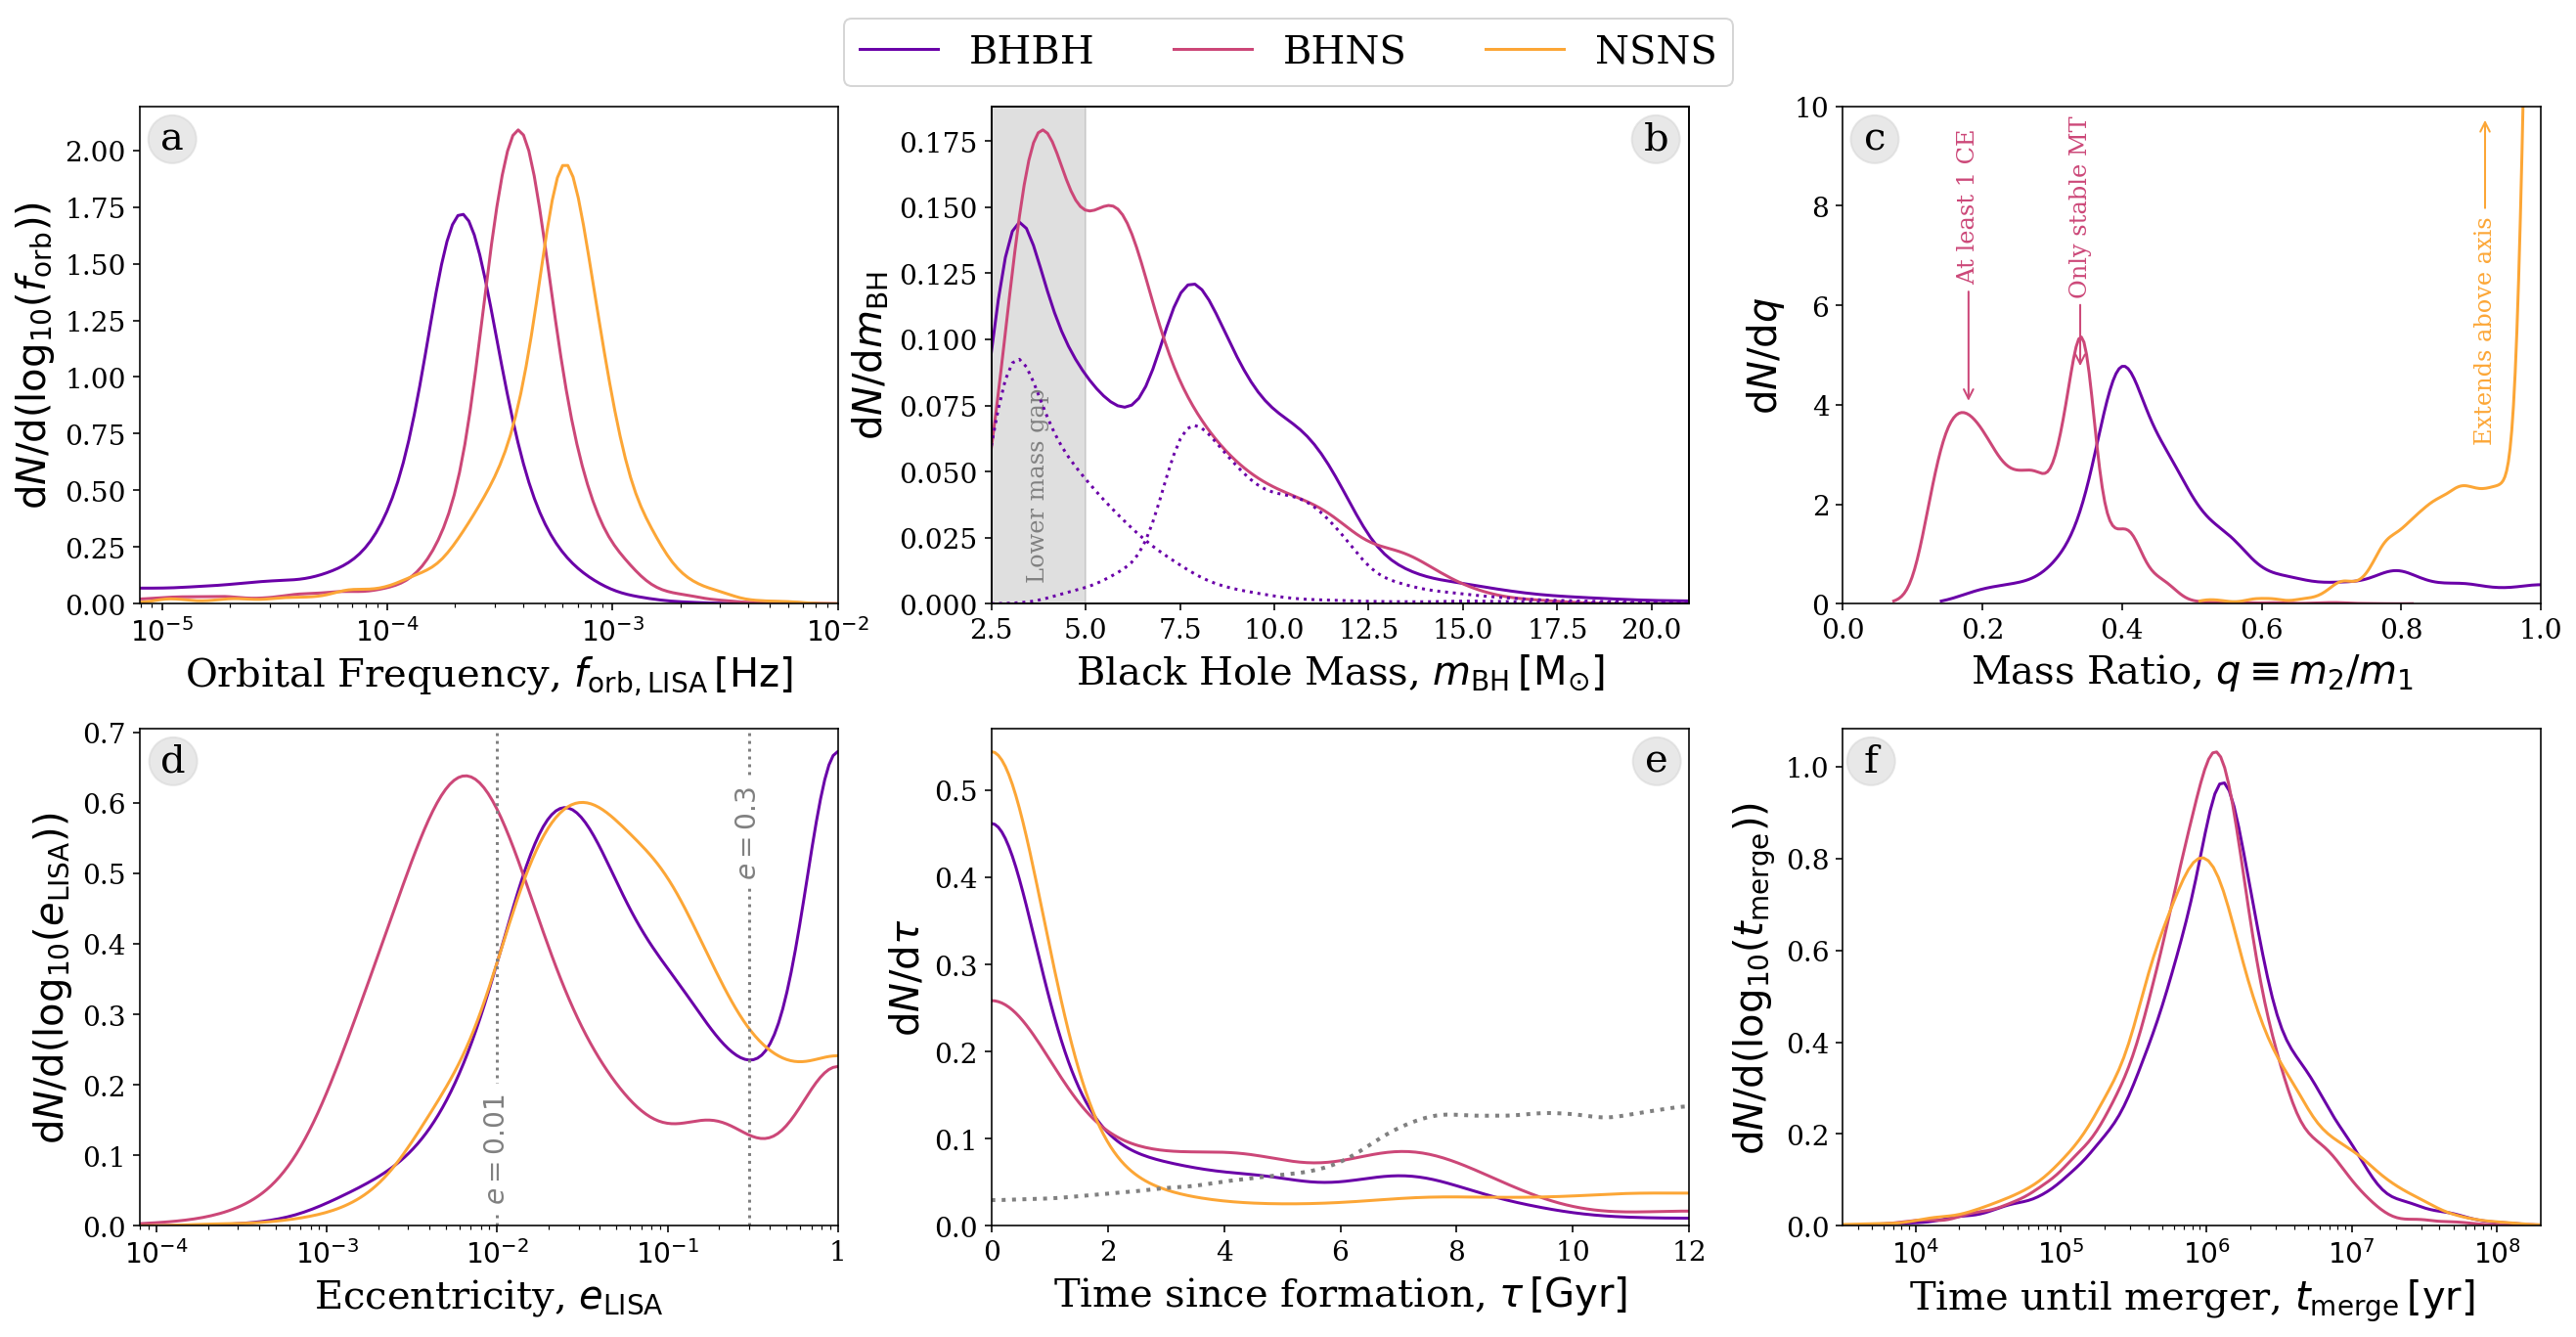

(<Figure size 1584x720 with 7 Axes>,
 array([[<AxesSubplot:xlabel='Orbital Frequency, $f_{\\rm orb, LISA} \\, [\\rm Hz]$', ylabel='$\\mathrm{d}N / \\mathrm{d}(\\log_{10} (f_{\\rm orb}))$'>,
         <AxesSubplot:xlabel='Black Hole Mass, $m_{\\rm BH} \\, [\\rm M_{\\odot}]$', ylabel='$\\mathrm{d}N / \\mathrm{d} m_{\\rm BH}$'>,
         <AxesSubplot:xlabel='Mass Ratio, $q \\equiv m_{2} / m_{1}$', ylabel='$\\mathrm{d}N / \\mathrm{d}q$'>],
        [<AxesSubplot:xlabel='Eccentricity, $e_{\\rm LISA}$', ylabel='$\\mathrm{d}N / \\mathrm{d}(\\log_{10} (e_{\\rm LISA}))$'>,
         <AxesSubplot:xlabel='Time since formation, $\\tau \\, [\\rm Gyr]$', ylabel='$\\mathrm{d}N / \\mathrm{d}\\tau$'>,
         <AxesSubplot:xlabel='Time until merger, $t_{\\rm merge} \\, [\\rm yr]$', ylabel='$\\mathrm{d}N / \\mathrm{d}(\\log_{10} (t_{\\rm merge}))$'>]],
       dtype=object))

In [41]:
detectable_properties_grid(lower_mass_gap=True, eccentricity_labels=True, bootstraps=None)

## Distance distribution
Finally, we can make a single panel KDE for the distance distribution of the sources in the Milky Way

In [648]:
def distance_distribution(model=0, t_obs=4 * u.yr, bootstraps=200, dco_types=dco_types,
                          colours=dco_colours, save_fig=True, file_name=None,
                          fig=None, ax=None, show=True, legend=True):
    
    start = time.time()

    detection_total = detections_4yr if t_obs == 4 * u.yr else detections_10yr
    
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(7, 5))
    lw = 4
    
    _, distances, _ = simulate_mw(10000)
    if bootstraps is not None:
        ax = boots.bootstrapped_kde(distances.value, np.ones_like(distances.value), np.linspace(0, len(distances), len(distances)), ax=ax, color="lightgrey",
                                    label="Stellar density", bootstraps=bootstraps, lower_bound=0.0, x_min=0, x_max=25, zorder=-1)
    else:
        kde = boots.MirroredKDE(distances.value, weights=np.ones_like(distances.value), lower_bound=0.0)
        x_vals, kde_vals = kde.evaluate(x_min=0, x_max=25)
        ax.plot(x_vals, kde_vals, color="lightgrey", label="Stellar density")
    
    # loop over each DCO type
    for i, dco_type in enumerate(dco_types):
        # open corresponding COMPAS file
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[model]["file"]), "r") as f:
            full_data = f["simulation"][...].squeeze()
            snr_mask = full_data["snr"] * (t_obs / (4 * u.yr))**(0.5) > 7

            data = full_data[snr_mask]

        # plot the distance distribution
        print("Plotting distance for", dco_type)
        if bootstraps is not None:
            ax = boots.bootstrapped_kde(data["dist"], data["weight"], data["seed"], ax=ax, color=colours[dco_type],
                                        label=dco_type, bootstraps=bootstraps, lower_bound=0.0, x_min=0, x_max=25)
        else:
            kde = boots.MirroredKDE(data["dist"], weights=data["weight"], lower_bound=0.0)
            x_vals, kde_vals = kde.evaluate(x_min=0, x_max=25)
            ax.plot(x_vals, kde_vals, color=colours[dco_type], label=dco_type)

    ax.set_xlabel(r"Distance, $D \, [\rm kpc]$")
    ax.set_xlim(0, 25)

    if legend:
        ax.legend(loc='upper right', fontsize=0.7*fs)

    ax.tick_params(labelsize=0.7*fs)
    ax.set_ylabel(r"$\mathrm{d}N / \mathrm{d} D$")
    ax.xaxis.label.set_fontsize(fs)

    ax.set_ylim(bottom=0.0)

    if save_fig:
        if file_name is not None:
            plt.savefig("../../paper/figures/" + file_name, format="pdf", bbox_inches="tight")
        elif t_obs == 4 * u.yr:
            plt.savefig("../../paper/figures/detectable_distance_distribution_4yr.pdf", format="pdf", bbox_inches="tight")
        else:
            plt.savefig("../../paper/figures/detectable_distance_distribution_10yr.pdf", format="pdf", bbox_inches="tight")
        
    print()
    print("Plot complete, it took {:1.1f} seconds".format(time.time() - start))

    if show:
        plt.show()
    
    return fig, ax

Plotting distance for BHBH
Plotting distance for BHNS
Plotting distance for NSNS

Plot complete, it took 168.3 seconds


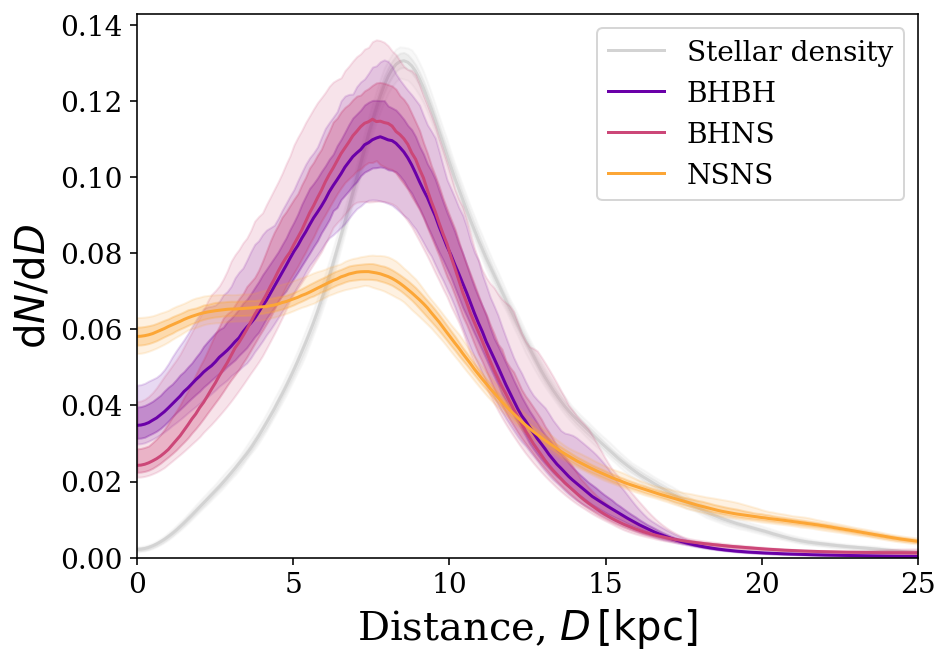

(<Figure size 504x360 with 1 Axes>,
 <AxesSubplot:xlabel='Distance, $D \\, [\\rm kpc]$', ylabel='$\\mathrm{d}N / \\mathrm{d} D$'>)

In [650]:
distance_distribution()

# Measurement uncertainties
This section deals with the plots of measurement uncertainties and therefore we first calculate a lot of the necessary parameters and then plot a series of very similar cumulative distribution functions.

In [669]:
detectable_harmonics_4yr, snr_uncertainty_4yr, ecc_uncertainty_4yr, max_harmonics_4yr = unc.get_ecc_uncertainty(harmonic_threshold=3,
                                                                                                                model=variations[0]["file"],
                                                                                                                t_obs=4*u.yr)

In [673]:
detectable_harmonics_10yr, snr_uncertainty_10yr, ecc_uncertainty_10yr, max_harmonics_10yr = unc.get_ecc_uncertainty(harmonic_threshold=3,
                                                                                                                    model=variations[0]["file"],
                                                                                                                    t_obs=10*u.yr,
                                                                                                                    folder="../../simulation/data/simulation_10yr/",
                                                                                                                    suffix="_10yr")

In [666]:
def snr_cumulative_all(model=0, bootstraps=200, save_fig=True, file_name=None):
    fig, ax = plt.subplots(figsize=(7, 5))
    lw = 4
    
    for t_obs in [4 * u.yr, 10 * u.yr]:
        detections = detections_4yr if t_obs == 4 * u.yr else detections_10yr
        folder = sim_folder if t_obs == 4 * u.yr else extended_sim_folder
    
        snrs = np.array([])
        weights = np.array([])
        seeds = np.array([])

        # loop over each DCO type
        for i, dco_type in enumerate(dco_types):
            # open corresponding COMPAS file
            with h5.File(folder + "{}_{}{}_all.h5".format(dco_type, variations[model]["file"], "" if t_obs == 4*u.yr else "_10yr"), "r") as f:
                data = f["simulation"][...].squeeze()

            new_weights = data["weight"] / data["weight"].sum() * detections[i][model].mean()    

            snrs = np.concatenate((snrs, data["snr"]))
            weights = np.concatenate((weights, new_weights))
            seeds = np.concatenate((seeds, data["seed"]))

        if bootstraps is not None:
            ax = boots.bootstrapped_ecdf(snrs, weights=weights, seeds=seeds, normalisation=detections[:, 0].mean(axis=1).sum(), ax=ax,
                                         log_scale=(True, False), bootstraps=bootstraps, color="tab:blue" if t_obs == 4 * u.yr else "teal",
                                         label="4 years" if t_obs == 4 * u.yr else "10 years")
        else:
            sns.ecdfplot(x=np.log10(snrs), weights=weights, ax=ax, log_scale=(False, False),
                         color="tab:blue" if t_obs == 4 * u.yr else "teal",
                         label="4 years" if t_obs == 4 * u.yr else "10 years")

    ax.set_xlabel(r"Signal-to-Noise Ratio, $\rho$")
        
    for lim in [10, 50, 100]:
        if bootstraps is None:
            x_lim = np.log10(lim)
            y_lim = 0.15 if lim > 10 else 0.85
        else:
            x_lim = lim
            y_lim = 30 if lim > 10 else 185
        ax.axvline(x_lim, color="grey", linestyle="dotted")
        ax.annotate(r"$\rho = {{{:}}}$".format(lim), xy=(x_lim, y_lim), ha="center", va="center", rotation=90,
                    color="grey", fontsize=0.7 * fs, bbox=dict(boxstyle="round", color="white", pad=0))

    ax.tick_params(labelsize=0.7*fs)
    ax.xaxis.label.set_fontsize(fs)

    if bootstraps is None:
        ax.set_xlim(right=3)
    else:
        ax.set_xlim(right=1e3)
    ax.set_ylim(bottom=0)
        
    ax.set_ylabel("Cumulative detections")
    
    leg = ax.legend(loc="lower right", fontsize=0.7*fs)
    leg.set_title("Mission Length")
    leg.get_title().set_fontsize(0.6*fs)

    if save_fig:
        if file_name is not None:
            plt.savefig(file_name, format="pdf", bbox_inches="tight")
        else:
            plt.savefig("../figures/snr_cumulative_all.pdf", format="pdf", bbox_inches="tight")

    plt.show()

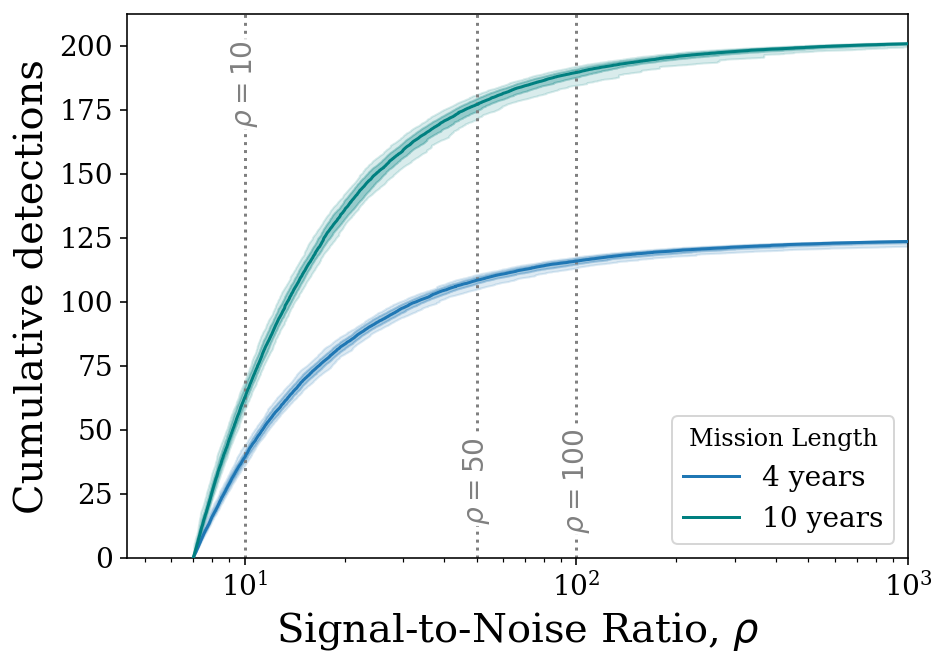

In [663]:
snr_cumulative_all()

In [697]:
def chirp_mass_uncertainty_all(model=0, bootstraps=200, save_fig=True, file_name=None):
    fig, ax = plt.subplots(figsize=(7, 5))
    lw = 4
    
    for t_obs in [4 * u.yr, 10 * u.yr]:
        detections = detections_4yr if t_obs == 4 * u.yr else detections_10yr
        max_harmonics = max_harmonics_4yr if t_obs == 4 * u.yr else max_harmonics_10yr
        ecc_uncertainty = ecc_uncertainty_4yr if t_obs == 4 * u.yr else ecc_uncertainty_10yr
        folder = sim_folder if t_obs == 4 * u.yr else extended_sim_folder
    
        uncertainties = np.array([])
        weights = np.array([])
        seeds = np.array([])

        # loop over each DCO type
        for i, dco_type in enumerate(dco_types):
            # open corresponding COMPAS file
            with h5.File(folder + "{}_{}{}_all.h5".format(dco_type, variations[model]["file"], "" if t_obs == 4*u.yr else "_10yr"), "r") as f:
                data = f["simulation"][...].squeeze()

            f_orb_LISA = legwork.utils.get_f_orb_from_a(m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun,
                                                    a=data["a_LISA"] * u.AU)

            m_c = legwork.utils.chirp_mass(data["m_1"], data["m_2"]) * u.Msun
            f_orb_dot = legwork.utils.fn_dot(m_c=m_c, f_orb=f_orb_LISA, e=data["e_LISA"], n=1)

            D_Mc = unc.get_m_c_uncertainty(f_orb_LISA * max_harmonics[dco_type], f_orb_dot * max_harmonics[dco_type],
                                       data["e_LISA"], ecc_uncertainty[dco_type], data["snr"], t_obs).decompose().value
                
            new_weights = data["weight"] / data["weight"].sum() * detections[i][model].mean()    

            uncertainties = np.concatenate((uncertainties, D_Mc))
            weights = np.concatenate((weights, new_weights))
            seeds = np.concatenate((seeds, data["seed"]))

        if bootstraps is not None:
            ax = boots.bootstrapped_ecdf(uncertainties, weights=weights, seeds=seeds, normalisation=detections[:, 0].mean(axis=1).sum(), ax=ax,
                                         log_scale=(True, False), bootstraps=bootstraps, color="tab:blue" if t_obs == 4 * u.yr else "teal",
                                         label="4 years" if t_obs == 4 * u.yr else "10 years")
            ax.set_xlim(9e-5, 2e3)
            ax.axvspan(1.0, ax.get_xlim()[1], color="grey", zorder=10, alpha=0.2)
            ax.axvspan(0.1, 1, color="grey", zorder=10, alpha=0.1)
        else:
            sns.ecdfplot(x=np.log10(uncertainties), weights=weights, ax=ax, log_scale=(False, False),
                         color="tab:blue" if t_obs == 4 * u.yr else "teal",
                         label="4 years" if t_obs == 4 * u.yr else "10 years")
            ax.set_xlim(np.log10(9e-5), np.log10(2e3))
            ax.axvspan(0, ax.get_xlim()[1], color="grey", zorder=10, alpha=0.2)
            ax.axvspan(-1, 0, color="grey", zorder=10, alpha=0.1)

    ax.set_xlabel(r"Chirp Mass Error, $\Delta \mathcal{M}_c / \mathcal{M}_c$")
    ax.tick_params(labelsize=0.7*fs)
    ax.xaxis.label.set_fontsize(fs)

    ax.set_ylim(bottom=0)
        
    ax.set_ylabel("Cumulative detections")
    
    leg = ax.legend(loc="upper left", fontsize=0.7*fs)
    leg.set_title("Mission Length")
    leg.get_title().set_fontsize(0.6*fs)

    if save_fig:
        if file_name is not None:
            plt.savefig(file_name, format="pdf", bbox_inches="tight")
        else:
            plt.savefig("../figures/chirp_mass_uncertainty_all.pdf", format="pdf", bbox_inches="tight")

    plt.show()

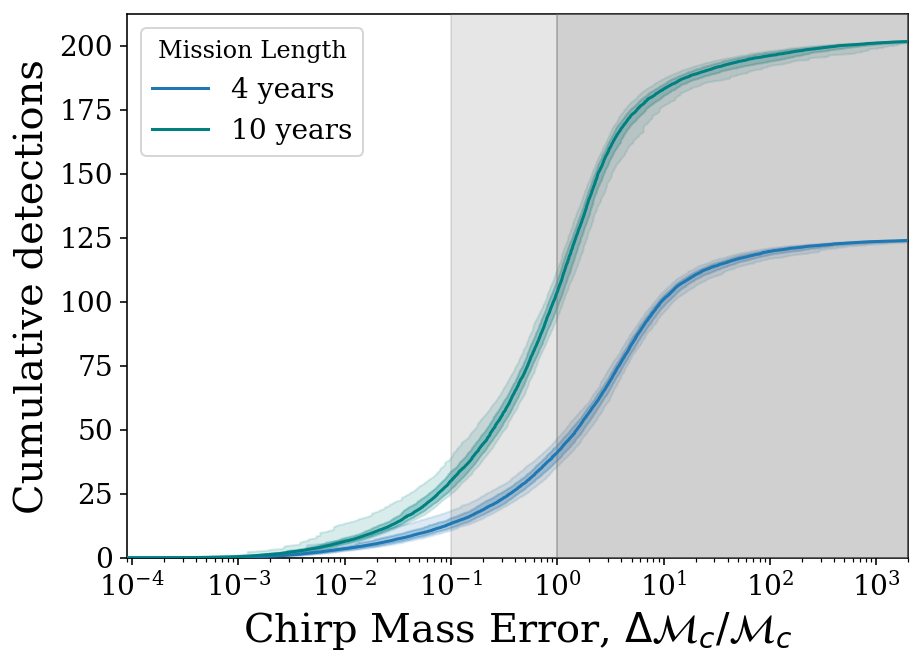

In [712]:
chirp_mass_uncertainty_all()

In [709]:
def angular_resolution_all(model=0, bootstraps=200, save_fig=True, file_name=None):
    fig, ax = plt.subplots(figsize=(7, 5))
    lw = 4
    
    for t_obs in [4 * u.yr, 10 * u.yr]:
        detections = detections_4yr if t_obs == 4 * u.yr else detections_10yr
        max_harmonics = max_harmonics_4yr if t_obs == 4 * u.yr else max_harmonics_10yr
        folder = sim_folder if t_obs == 4 * u.yr else extended_sim_folder
    
        uncertainties = np.array([])
        weights = np.array([])
        seeds = np.array([])

        # loop over each DCO type
        for i, dco_type in enumerate(dco_types):
            # open corresponding COMPAS file
            with h5.File(folder + "{}_{}{}_all.h5".format(dco_type, variations[model]["file"], "" if t_obs == 4*u.yr else "_10yr"), "r") as f:
                data = f["simulation"][...].squeeze()

            f_orb_LISA = legwork.utils.get_f_orb_from_a(m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun,
                                                    a=data["a_LISA"] * u.AU)

            m_c = legwork.utils.chirp_mass(data["m_1"], data["m_2"]) * u.Msun
            sigma_theta = unc.sky_localisation(data["snr"], f_orb_LISA * max_harmonics[dco_type]).to(u.deg).value
                
            new_weights = data["weight"] / data["weight"].sum() * detections[i][model].mean()    

            uncertainties = np.concatenate((uncertainties, sigma_theta))
            weights = np.concatenate((weights, new_weights))
            seeds = np.concatenate((seeds, data["seed"]))

        if bootstraps is not None:
            ax = boots.bootstrapped_ecdf(uncertainties, weights=weights, seeds=seeds, normalisation=detections[:, 0].mean(axis=1).sum(), ax=ax,
                                         log_scale=(True, False), bootstraps=bootstraps, color="tab:blue" if t_obs == 4 * u.yr else "teal",
                                         label="4 years" if t_obs == 4 * u.yr else "10 years")
            ax.set_xlim(5e-3, 5e1)
            
            for lim, label in [(0.5, "0.5 deg"), (1, "1 deg"), (10, "10 deg")]:
                ax.axvline(lim, color="grey", linestyle="dotted")
                ax.annotate(label, xy=(lim, 200 if lim <= 1 else 10), ha="center", va="top" if lim <= 1 else "bottom", rotation=90, color="grey",
                            fontsize=0.7*fs, bbox=dict(boxstyle="round", color="white", pad=0.1))
        else:
            sns.ecdfplot(x=np.log10(uncertainties), weights=weights, ax=ax, log_scale=(False, False),
                         color="tab:blue" if t_obs == 4 * u.yr else "teal",
                         label="4 years" if t_obs == 4 * u.yr else "10 years")
            ax.set_xlim(np.log10(5e-3), np.log10(5e1))
        
    ax.set_xlabel(r"Angular Resolution, $\sigma_{\theta} \ [{\rm deg}]$")
    ax.tick_params(labelsize=0.7*fs)
    ax.xaxis.label.set_fontsize(fs)
    
    ax.set_ylim(bottom=0)
        
    ax.set_ylabel("Cumulative detections")
    
    leg = ax.legend(loc="upper left", fontsize=0.7*fs)
    leg.set_title("Mission Length")
    leg.get_title().set_fontsize(0.6*fs)

    if save_fig:
        if file_name is not None:
            plt.savefig(file_name, format="pdf", bbox_inches="tight")
        else:
            plt.savefig("../figures/angular_resolution_all.pdf", format="pdf", bbox_inches="tight")

    plt.show()

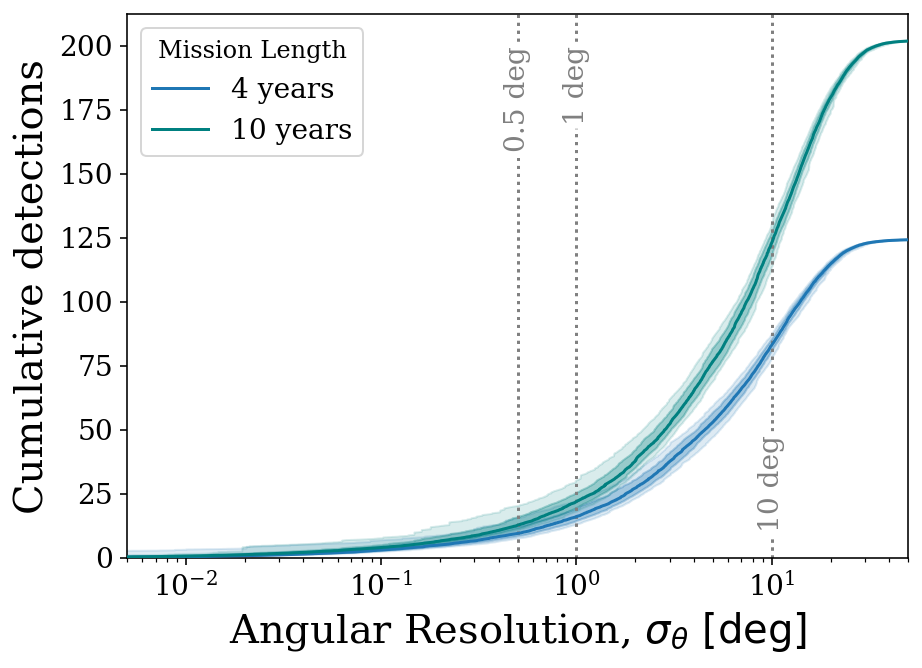

In [711]:
angular_resolution_all()